# Support vector machines

In [1]:
# import libraries

import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns

from matplotlib.backends.backend_pdf import PdfPages
from sklearn.decomposition import PCA

from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.feature_selection import GenericUnivariateSelect, mutual_info_classif, mutual_info_regression, f_regression, f_classif

from sklearn import preprocessing
from sklearn.svm import LinearSVR
from sklearn.svm import LinearSVC
from sklearn.svm import SVR
from sklearn.svm import SVC
from sklearn import linear_model

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import r2_score
from sklearn.metrics.pairwise import pairwise_kernels

from sklearn import model_selection

from sklearn.impute import KNNImputer
from sklearn.impute import SimpleImputer
# explicitly require this experimental feature
from sklearn.experimental import enable_iterative_imputer  # noqa
# now you can import normally from sklearn.impute
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

import copy

## Data pre-processing

In [2]:
# load training data

# load data from csv file
df_train_features = pd.read_csv ('train_features.csv')
df_train_labels = pd.read_csv('train_labels.csv')

# Load test data
df_test_features = pd.read_csv('test_features.csv')

### Sorting labels

In [3]:
df_train_labels = df_train_labels.sort_values('pid')
df_train_features = df_train_features.sort_values('pid')
df_test_features = df_test_features.sort_values('pid')

# Droping time
df_train_features = df_train_features.drop('Time', axis = 1)
df_test_features = df_test_features.drop('Time', axis = 1)

### Extracting IDs

In [4]:
train_pids = df_train_features['pid'].unique()
test_pids = df_test_features['pid'].unique()

 ### Histogram of the output labels 

We should check for class imbalance.

In [ ]:
df_train_labels.hist()

# with PdfPages("./Results/Labels_histogram.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

One can see the class imbalance problem here. Other observations:
  * Heartrate, RRate, ABPm,  distribution is similar to a normal distribution
  * SpO2 is like a censored normal distribution. 
  * For all of the other features, class imbalance is an obvious problem.

A basic strategy that could be used here: Upsample both classes! Do the upsampling efficiently, not just replicating the datapoints

### Boxplot over features

In [ ]:
# data inspection: 
#############################################
# range of the provided data?
print(df_train_features.agg([min, max]))

# Boxplotting the data
# fig2, ax2 = plt.subplots()
# ax2.set_title('BUN')
# ax2.boxplot(df_train_features.iloc[:,5], notch=True)

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = df_train_features.iloc[:,1:])
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=90,
    horizontalalignment='right'
);

# with PdfPages("./Results/Train_columns_boxplot.pdf") as export_pdf:
#     for i in list(df_train_labels)[1:]:
#         df_train_labels.hist(column = i, bins = 100)
#         export_pdf.savefig()

In [ ]:
# calculate the correlation matrix
corr = df_train_features.corr()

# plot the heatmap
plt.figure(figsize=(16, 16))
ax = sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns, 
        vmin=-1, vmax=1, center=0, 
           cmap=sns.diverging_palette(20, 220, n=200))
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### Visualizing pattern of missing values

In [ ]:
# how much missing data? 
print("Percentage of missing values:")
print(df_train_features.isnull().sum(axis=0) / len(df_train_features))

msno.matrix(df_train_features)

# Plotting the correlation between the missing values
msno.heatmap(df_train_features)

# Another Strategy for preprocessing

In [6]:
# Which columns have less than a percent NA
NA_percent = 0.85
NA_percent_severe = 0.91

sel_features = df_train_features.isnull().sum(axis=0) < (NA_percent * df_train_features.shape[0])
inds = np.where(sel_features == True)

sel_features_2 = (df_train_features.isnull().sum(axis=0) <= (NA_percent_severe * df_train_features.shape[0])) & (df_train_features.isnull().sum(axis=0) >= (NA_percent * df_train_features.shape[0]))        
inds_2 = np.where(sel_features_2 == True)

sel_features_3 = df_train_features.isnull().sum(axis=0) > (NA_percent_severe * df_train_features.shape[0])
inds_3 = np.where(sel_features_3 == True)

vars_class1 = df_train_features.columns[inds[0]]
vars_class2 = df_train_features.columns[inds_2[0]]
vars_class3 = df_train_features.columns[inds_3[0]]
vars_classes = [vars_class1, vars_class2, vars_class3]

print("--------Our Columns are are: ",df_train_features.columns.drop("pid"))
print("--------Labels are: ", df_train_labels.columns)
print("********Var classes are: " ,vars_classes)

--------Our Columns are are:  Index(['Age', 'EtCO2', 'PTT', 'BUN', 'Lactate', 'Temp', 'Hgb', 'HCO3',
       'BaseExcess', 'RRate', 'Fibrinogen', 'Phosphate', 'WBC', 'Creatinine',
       'PaCO2', 'AST', 'FiO2', 'Platelets', 'SaO2', 'Glucose', 'ABPm',
       'Magnesium', 'Potassium', 'ABPd', 'Calcium', 'Alkalinephos', 'SpO2',
       'Bilirubin_direct', 'Chloride', 'Hct', 'Heartrate', 'Bilirubin_total',
       'TroponinI', 'ABPs', 'pH'],
      dtype='object')
--------Labels are:  Index(['pid', 'LABEL_BaseExcess', 'LABEL_Fibrinogen', 'LABEL_AST',
       'LABEL_Alkalinephos', 'LABEL_Bilirubin_total', 'LABEL_Lactate',
       'LABEL_TroponinI', 'LABEL_SaO2', 'LABEL_Bilirubin_direct',
       'LABEL_EtCO2', 'LABEL_Sepsis', 'LABEL_RRate', 'LABEL_ABPm',
       'LABEL_SpO2', 'LABEL_Heartrate'],
      dtype='object')
********Var classes are:  [Index(['pid', 'Age', 'Temp', 'RRate', 'Glucose', 'ABPm', 'ABPd', 'SpO2',
       'Heartrate', 'ABPs'],
      dtype='object'), Index(['Hgb', 'PaCO2', 'FiO2', '

In [8]:
# Extract Statistics out of columns
train_columns_mean = df_train_features.mean(skipna = True)
train_columns_median = df_train_features.median(skipna = True)

# Extract Statistics out of test
test_columns_mean = df_test_features.mean(skipna = True)
test_columns_median = df_test_features.median(skipna = True)

In [ ]:
# df
x =[1,2,3,np.NaN,5]
print(np.isnan(x))
[i for count,i in enumerate(x) if ~np.isnan(i)]

In [9]:
def imputation_pid(df, IMPUTATIONS_TRATEGY, trainStats):

    datInp = copy.deepcopy(df)

    totNACounts = datInp.isna().sum(axis = 0)
    # def imputation_technique(datInp, var, IMPUTATIONS_TRATEGY, trainStats):

    # do it in a sorted fashion to do iterative imputing
    col_size = df.shape[1]
    df_NACount = pd.DataFrame({'NACounts':totNACounts, 'Columns':list(datInp), 'ColNum':np.linspace(0,col_size - 1, col_size, dtype = int)}).sort_values('NACounts', ascending = False)
    for index, row in df_NACount.iterrows():

    #     var = dataInp[:,row[2]].tolist()
    #     print(var)
        if(row[0] == 12):
            datInp.iloc[:,row[2]] = [trainStats[row[2]]] * 12

        elif(row[0] == 11):
            # If 11, then copy that element 11 times
            datInp.iloc[:,row[2]] = [ [i for count,i in enumerate(datInp.iloc[:,row[2]]) if ~np.isnan(i)][0] ] * 12
    
    dataInp = IMPUTATIONS_TRATEGY.fit_transform(datInp)
    
    return(pd.DataFrame(dataInp, columns = list(datInp)))

In [ ]:
arr = np.linspace(1,10, 10, dtype = int)
arr = []
for i in range(12):
    arr.append("v" + str(i))
print(arr)

In [11]:
from scipy import stats

def aggregation_imputation_technique(datInp, variables, vars_classes, pids, trainStats):
    vars_class1 = vars_classes[0]
    vars_class2 = vars_classes[1]
    vars_class3 = vars_classes[2]
    
    dat = copy.deepcopy(datInp)
    
    vars_class1 = vars_classes[0]
    vars_class2 = vars_classes[1]
    vars_class3 = vars_classes[2]
    
    aggregated_dataframe = []
    for pid in pids:
        # dataframe for this pid
        df = dat.loc[dat['pid'] == pid]
        
        imputer = KNNImputer(n_neighbors=2)

        df = imputation_pid(df, imputer, trainStats)
        
        calculated_features = []
        col_names = []
        for var in variables:
            
            # how many NaN are in there for this variable
            data = df[var].tolist()
            
            if var == "pid":
                continue
                
            if var == "Age":
                arr = "Age"
                col_names.append(arr)
                calculated_features.append(data[0])
                
            elif var in vars_class1:
                for i in range(12):
                    col_names.append(var + ":" + str(i))
                
                calculated_features = calculated_features + data
                calculated_features.append(np.nanmean(data))
                calculated_features.append(np.nanstd(data))
                calculated_features.append(stats.iqr(data, nan_policy = "omit"))
                
                col_names.append(var + ":mean")
                col_names.append(var + ":std")
                col_names.append(var + ":iqr")
                
            elif var in vars_class2:
                calculated_features.append(np.nanmean(data))
                calculated_features.append(np.nanstd(data))
                calculated_features.append(np.nanmin(data))
                calculated_features.append(np.nanmax(data))
                calculated_features.append(stats.iqr(data, nan_policy = "omit"))
                
                col_names.append(var + ":mean")
                col_names.append(var + ":std")
                col_names.append(var + ":min")
                col_names.append(var + ":max")
                col_names.append(var + ":iqr")
            
            else:
                calculated_features.append(np.nanmean(data))
                calculated_features.append(np.nanstd(data))
                calculated_features.append(np.nanmin(data))
                calculated_features.append(np.nanmax(data))
                
                col_names.append(var + ":mean")
                col_names.append(var + ":std")
                col_names.append(var + ":min")
                col_names.append(var + ":max")
                
        aggregated_dataframe.append(calculated_features)
        
    aggregated_dataframe = pd.DataFrame(aggregated_dataframe, columns = col_names)
        
    return(aggregated_dataframe)

df_train_agg_features = aggregation_imputation_technique(df_train_features, df_train_features.columns, vars_classes,
                                                         train_pids, train_columns_mean)
df_train_agg_features

,Age,EtCO2:mean,EtCO2:std,EtCO2:min,EtCO2:max,PTT:mean,PTT:std,PTT:min,PTT:max,BUN:mean,...,ABPs:10,ABPs:11,ABPs:mean,ABPs:std,ABPs:iqr,pH:mean,pH:std,pH:min,pH:max,pH:iqr
0,34.0,32.883114,7.105427e-15,32.883114,32.883114,40.09131,7.105427e-15,40.09131,40.09131,12.000000,...,125.0,106.0,114.500000,11.572237,16.250,7.379167,2.430992e-02,7.330000,7.410000,0.020
1,86.0,32.883114,7.105427e-15,32.883114,32.883114,31.80000,0.000000e+00,31.80000,31.80000,32.000000,...,148.0,131.5,131.208333,7.787432,10.750,7.367231,8.881784e-16,7.367231,7.367231,0.000
2,66.0,32.883114,7.105427e-15,32.883114,32.883114,34.60000,7.105427e-15,34.60000,34.60000,8.000000,...,86.0,90.0,123.083333,29.380998,52.750,7.367231,8.881784e-16,7.367231,7.367231,0.000
3,66.0,32.883114,7.105427e-15,32.883114,32.883114,53.80000,7.105427e-15,53.80000,53.80000,32.000000,...,97.0,100.0,100.666667,5.527708,7.750,7.353333,1.699673e-02,7.330000,7.390000,0.015
4,42.0,32.883114,7.105427e-15,32.883114,32.883114,40.09131,7.105427e-15,40.09131,40.09131,18.000000,...,149.0,209.0,204.291667,24.992047,34.000,7.367231,8.881784e-16,7.367231,7.367231,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18990,52.0,32.883114,7.105427e-15,32.883114,32.883114,25.80000,0.000000e+00,25.80000,25.80000,11.000000,...,91.0,86.5,87.958333,5.088624,4.625,7.330000,8.881784e-16,7.330000,7.330000,0.000
18991,66.0,32.883114,7.105427e-15,32.883114,32.883114,40.09131,7.105427e-15,40.09131,40.09131,33.000000,...,172.0,163.0,165.583333,10.387960,16.750,7.367231,8.881784e-16,7.367231,7.367231,0.000
18992,44.0,32.883114,7.105427e-15,32.883114,32.883114,40.09131,7.105427e-15,40.09131,40.09131,15.000000,...,114.0,104.5,101.000000,9.744657,12.875,7.301250,2.227901e-02,7.250000,7.340000,0.020
18993,70.0,32.883114,7.105427e-15,32.883114,32.883114,40.09131,7.105427e-15,40.09131,40.09131,23.192664,...,109.0,105.0,110.250000,6.029442,7.000,7.367231,8.881784e-16,7.367231,7.367231,0.000


In [12]:
# scale the data

min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_features)
data_train_scaled = pd.DataFrame(data_train_scaled, columns = list(df_train_agg_features))

In [13]:
df_test_agg_features = aggregation_imputation_technique(df_test_features, df_test_features.columns, vars_classes,
                                                        test_pids, test_columns_mean)

min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_test_scaled = min_max_scaler.fit_transform(df_test_agg_features)
data_test_scaled = pd.DataFrame(data_test_scaled, columns = list(df_test_agg_features))

In [14]:
print(data_test_scaled.shape)
print(data_train_scaled.shape)

(12664, 231)
(18995, 231)


In [15]:
pd.DataFrame(data_train_scaled).to_csv("./Results/other_dat_train_scaled_2.csv", index = False)
pd.DataFrame(data_test_scaled).to_csv("./Results/other_dat_test_scaled_2.csv", index = False)

# Previous approach for preprocessing

### Train data pre-processing

In [ ]:
# Which columns have less than a percent NA
NA_percent = 0.7
NA_percent_severe = 0.91

sel_features = df_train_features.isnull().sum(axis=0) < (NA_percent * df_train_features.shape[0])
inds = np.where(sel_features == True)

sel_features_2 = (df_train_features.isnull().sum(axis=0) < (NA_percent_severe * df_train_features.shape[0])) & (df_train_features.isnull().sum(axis=0) > (NA_percent * df_train_features.shape[0]))        
inds_2 = np.where(sel_features_2 == True)

sel_features_3 = df_train_features.isnull().sum(axis=0) > (NA_percent_severe * df_train_features.shape[0])
inds_3 = np.where(sel_features_3 == True)

vars_class1 = df_train_features.columns[inds[0]]
vars_class2 = df_train_features.columns[inds_2[0]]
vars_class3 = df_train_features.columns[inds_3[0]]
vars_classes = [vars_class1, vars_class2, vars_class3]

print("--------Our Columns are are: ",df_train_features.columns.drop("pid"))
print("--------Labels are: ", df_train_labels.columns)
print("********Var classes are: " ,vars_classes)

In [ ]:
def aggregation_technique(dat, variables, pids, vars_classes):
    
    vars_class1 = vars_classes[0]
    vars_class2 = vars_classes[1]
    vars_class3 = vars_classes[2]
    
    aggregated_dataframe = []
    for pid in pids:
        # dataframe for this pid
        df = dat.loc[dat['pid'] == pid]
        calculated_features = []
        for var in variables:
            # how many NaN are in there for this variable
            data = df[var].tolist()
#             num_nan = np.count_nonzero(np.isnan(data))
            if var == "Age":
                calculated_features.append(data[0])
                
            elif var in vars_class1:
                calculated_features = calculated_features + data
#                 calculated_features.append(np.nanmean(data))
#                 calculated_features.append(np.nanstd(data))
                
            elif var in vars_class2:
                calculated_features.append(np.nanmean(data))
                calculated_features.append(np.nanstd(data))
                calculated_features.append(np.nanmin(data))
                calculated_features.append(np.nanmax(data))
            else:
                calculated_features.append(np.nanmean(data))
#                 calculated_features.append(np.nanstd(data))
                
        aggregated_dataframe.append(calculated_features)
        
    aggregated_dataframe = pd.DataFrame(aggregated_dataframe)
    return(aggregated_dataframe)
 
train_pids = df_train_features['pid'].unique()
df_train_agg_features = aggregation_technique(df_train_features, df_train_features.columns.drop("pid"), train_pids, vars_classes)

In [ ]:
print(df_train_agg_features.shape)
print(df_train_agg_features.columns)
print(df_train_agg_features)
# pd.DataFrame(data_train_scaled)

In [ ]:
# print(train_pids[1:50])
# print(df_train_labels['pid'].tolist()[1:50])
print(np.nanmean(df_train_features['Age'].tolist()))
print(np.nanvar(df_train_features['Age'].tolist()))

In [ ]:
# # Run the imputer with a simple Random Forest estimator
# imp = IterativeImputer(RandomForestRegressor(n_estimators=5), max_iter=10, random_state=1)

# #perform filling
# df_train_agg_imputed_features = pd.DataFrame(imp.fit_transform(df_train_agg_features), columns=df_train_agg_features.columns)

In [ ]:
# impute missing data points
#imp = SimpleImputer(strategy="mean")
imputer = KNNImputer(n_neighbors = 10)

df_train_agg_imputed_features = imputer.fit_transform(df_train_agg_features)

In [ ]:
# scale the data
min_max_scaler = preprocessing.StandardScaler()
# standard_scalar = preprocessing.StandardScaler()

data_train_scaled = min_max_scaler.fit_transform(df_train_agg_imputed_features)

In [ ]:
# Visualizing the training data after imputing and aggregating

plt.figure(figsize=(16, 16))
ax = sns.boxplot(data = pd.DataFrame(data_train_scaled))
ax.set_xticklabels(
    list(df_train_features),
    rotation=90,
    horizontalalignment='right'
);

In [ ]:
# What is the correlation between the 
pd.DataFrame(data_train_scaled).corrwith(other = pd.DataFrame(df_train_agg_imputed_features), method = "spearman").transpose()

### PCA plot 

In [ ]:
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(data_train_scaled)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

finalDf = pd.concat([principalDf, df_train_labels[[df_train_labels.columns[1]]]], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Principal Component 1', fontsize = 15)
ax.set_ylabel('Principal Component 2', fontsize = 15)
ax.set_title('2 component PCA for label i', fontsize = 20)
targets = [0, 1]
colors = ['r', 'g', 'b']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf[df_train_labels.columns[1]] == target
    ax.scatter(finalDf.loc[indicesToKeep, 'principal component 1']
               , finalDf.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

### Test Data pre-processing

In [ ]:
test_pids = df_test_features['pid'].unique()
df_test_agg_features = aggregation_technique(df_test_features, df_test_features.columns.drop("pid"),
                                             test_pids, vars_classes)

In [ ]:
print(df_test_agg_features.isna().sum(axis = 0).tolist()[0:100])
print(df_train_agg_features.isna().sum(axis = 0).tolist()[0:100])

In [ ]:
# impute missing data points
# should we impute it with the same imputer that we've used for train?

imputer = KNNImputer(n_neighbors= 10)
df_test_agg_imputed_features = imputer.fit_transform(df_test_agg_features)

In [ ]:
# scale test data
min_max_scaler = preprocessing.StandardScaler()
data_test_scaled = min_max_scaler.fit_transform(df_test_agg_imputed_features)

In [ ]:
pd.DataFrame(data_train_scaled).to_csv("./Results/dat_train_robust_scaled.csv", index = False)
pd.DataFrame(data_test_scaled).to_csv("./Results/dat_test_robust_scaled.csv", index = False)

In [ ]:
# If want to run from here:
# data_train_scaled = pd.read_csv("./Results/dat_train_scaled.csv")
# data_test_scaled = pd.read_csv("./Results/dat_test_scaled.csv")

## Fit a model & Predict

### predict with support vector machine classification and use probabilities

In [ ]:
print(list(set(df_test_features.pid))[1:30])
test_pids = df_test_features['pid'].unique()
print(test_pids[1:30])

In [ ]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

from sklearn.utils import resample

for i in range(1, 12):
    
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=45)
    train_features = pd.DataFrame(transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i]))
    print("For feature ", df_train_labels.columns[i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = pd.DataFrame(transformer.transform(data_test_scaled))

    
    #clf = BaggingClassifier(SVC(kernel = 'poly', degree = 5, class_weight = 'balanced', verbose = True, C = 10))
    clf_w = SVC(kernel = 'rbf', class_weight = {0:1,1:50}, verbose = 2)
    
    parameters = {'C':(0.1, 1, 10, 20)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                        refit = True, scoring = 'roc_auc', verbose = 2,
                                       n_jobs=6, return_train_score = True)
    
#     weight_multiplier = 2
#     class_1 = df_train_labels.iloc[:,i] == 1
#     class_0 = df_train_labels.iloc[:,i] == 0

#     samples_count = int(np.sum(class_1)) * weight_multiplier
#     X = resample(train_features.loc[class_0,:],
#                     n_samples = samples_count, replace = False, random_state=0)
#     data_train = pd.concat([pd.DataFrame(X), pd.DataFrame(train_features.loc[class_1,:])], axis = 0)
#     data_label = ([0] * samples_count) + ([1] * int(samples_count / weight_multiplier))
#     print(data_train.shape)
#     print(len(data_label))

    clf.fit(train_features, df_train_labels.iloc[:,i])
#     clf.fit(train_features, labels)
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_features)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_features)
    probability_train = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability_train)):
        if distance_hyperplace_train[j] < 0:
            probability_train[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability_train[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    
    svc_disp = plot_roc_curve(clf, train_features, df_train_labels.iloc[:,i])
    plt.show()
    break

In [ ]:
# labels that have a real value
columns_2 = []
# from sklearn.kernel_ridge import KernelRidge

for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param =80)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    clf_w = SVR(kernel = 'rbf', cache_size = 6000)
# #     clf_w = NuSVR(nu=0.5, kernel = 'linear')
    parameters = {'C':(0.1, 1,10, 20)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
#     clf = KernelRidge(kernel = 'poly', degree = 5)
#     parameters = {'alpha':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf, param_grid = parameters, cv = 3,
#                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)

    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    

In [ ]:
columns_final = columns_1 + columns_2

### predict with Support vector regression and then compute sigmoid function

In [ ]:
# first for the labels that have an output [0,1]

# columns_1 = [test_pids]

# for i in range(1,12):
    
#     clf = SVR(kernel = 'poly', degree = 3, max_iter = 10000)
#     clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
#     pred = clf.predict(data_test_scaled)
#     prob = np.empty(len(pred))
#     for j in range(0, len(pred)):
#         prob[j] = 1 / (1 + math.exp(-pred[j]))
#     columns_1.append(prob)
    
#     pred_train = clf.predict(data_train_scaled)
#     prob_train = np.empty(len(pred_train))
#     for j in range(0, len(pred_train)):
#         prob_train[j] = 1 / (1 + math.exp(-pred_train[j]))    
#     tmp = roc_auc_score(y_score= prob_train, y_true= df_train_labels.iloc[:,i])
#     print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)


In [20]:
#labels that have a real value
from sklearn.metrics import make_scorer
columns_2 = []


for i in range(12, 16):
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= f_regression, mode ='k_best', param=60)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print(data_train_scaled.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    if(i == 14):
        # Bagging the regressor have been tried, does not help
        clf_w = SVR(kernel = 'rbf', tol = 1e-4, cache_size= 7000)
        
        # This parameter vector have been tried, 1 is the best
        #parameters = {'base_estimator__C':(0.001, 0.01, 0.1, 1,10, 20)}
        #parameters = {'C':np.linspace(0.1,1,10)}
        parameters = {'C':(0.001, 0.01, 0.1, 0.5, 1,10)}
    else:
        clf_w = LinearSVR()
        parameters = {'C':(0.001, 0.001, 0.01, 0.1,1,10)}
        
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 5,
                                       refit = True, scoring = make_scorer(r2_score), verbose = 2,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_features, df_train_labels.iloc[:,i])
        
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
    
    pred = clf.predict(test_features)
    columns_2.append(pred)
    
    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)


Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  30 out of  30 | elapsed:  5.0min finished


[0.10369489 0.23703688 0.28743009 0.34889453 0.39340107 0.66392145]
[0.10464513 0.23660007 0.27110972 0.28618495 0.28814006 0.28062418]
{'C': 1}
0.2881400557730167
R2 for feature LABEL_SpO2  :  0.3915944720764525


In [18]:
transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=60)
train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,14])
test_features = transformer.transform(data_test_scaled)

In [19]:
# df_train_agg_features.columns[transformer.get_support(indices = True)]
print(data_train_scaled.columns[transformer.get_support(indices = True)])
# transformer.get_support(indices = True)
# print(list(df_train_agg_features))

Index(['BUN:mean', 'Lactate:std', 'Lactate:max', 'Temp:4', 'Hgb:mean',
       'Hgb:min', 'Hgb:max', 'BaseExcess:max', 'RRate:4', 'RRate:8',
       'RRate:11', 'RRate:mean', 'RRate:std', 'WBC:mean', 'PaCO2:mean',
       'PaCO2:min', 'PaCO2:max', 'PaCO2:iqr', 'FiO2:mean', 'FiO2:std',
       'FiO2:min', 'FiO2:max', 'FiO2:iqr', 'Platelets:mean', 'Platelets:max',
       'SaO2:mean', 'SaO2:min', 'SaO2:max', 'Glucose:1', 'Glucose:2',
       'Glucose:4', 'Glucose:11', 'ABPm:0', 'ABPm:2', 'Calcium:std',
       'Calcium:min', 'SpO2:0', 'SpO2:1', 'SpO2:2', 'SpO2:3', 'SpO2:4',
       'SpO2:5', 'SpO2:6', 'SpO2:7', 'SpO2:8', 'SpO2:9', 'SpO2:10', 'SpO2:11',
       'SpO2:mean', 'SpO2:std', 'SpO2:iqr', 'Hct:min', 'Hct:max',
       'Heartrate:5', 'Heartrate:10', 'Heartrate:mean', 'ABPs:10', 'pH:mean',
       'pH:std', 'pH:min'],
      dtype='object')


In [ ]:
columns_final = columns_1 + columns_2

### Random forest

In [ ]:
# Random forest Classifier
columns_1 = [test_pids]
for i in range(1, 12):
    clf = RandomForestClassifier(min_samples_leaf=2, class_weight='balanced', oob_score=False, bootstrap=False)
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.oob_score)
    # compute probabilites as opposed to predictions
    probability = clf.apply(data_test_scaled)
    probs = [i[1] for i in probability] 
    columns_1.append(probs)
    
    
    probability = clf.predict_proba(data_train_scaled)

    probs = [i[1] for i in probability]            
    tmp = roc_auc_score(y_score= probs, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

# Kernelized Logistic Regression

In [ ]:
from sklearn.utils import resample
i = 1

# transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param = 40)
# train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
# #     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
# test_features = transformer.transform(data_test_scaled)


class_1 = df_train_labels.iloc[:,i] == 1
class_0 = df_train_labels.iloc[:,i] == 0
print(np.where(class_0)[0])

weight_multiplier = 2
samples_count = int(np.sum(df_train_labels.iloc[:,i])) * weight_multiplier
X = resample(train_features[np.where(class_0)[0]],
                n_samples = samples_count, replace = False, random_state=0)
data_train = pd.concat([pd.DataFrame(X), pd.DataFrame(train_features[np.where(class_1)[0]])], axis = 0)
data_label = ([0] * samples_count) + ([1] * int(samples_count / weight_multiplier))

print(data_train.shape)
print(len(data_label))

weights = data_train.shape[0] / (2 * np.bincount(df_train_labels.iloc[:,i]))
print(weights[0])
print(np.sum(class_1))
print(np.sum(class_0))

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    5.0s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   56.7s finished


[0.78621643 0.79218372 0.81871357 0.85390515 0.87553129 0.88350437
 0.88535318 0.88644408 0.88682871]
[0.78584646 0.79175759 0.81773693 0.85134619 0.86896359 0.87343802
 0.87382152 0.87383506 0.8737089 ]
{'C': 20}
0.8738350640425304
ROC AUC for feature LABEL_BaseExcess  :  0.8858997541469559


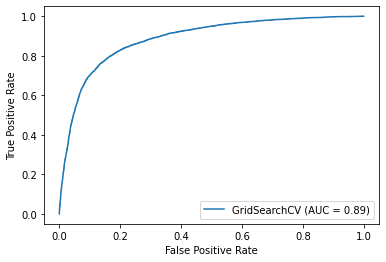

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.1min finished


[0.7161891  0.72002325 0.73726574 0.7673913  0.79768835 0.81177295
 0.81558664 0.81816615 0.81918864]
[0.71512267 0.71866144 0.73388314 0.75595193 0.76921782 0.76864459
 0.76620845 0.76339896 0.76198568]
{'C': 1}
0.7692178186811057
ROC AUC for feature LABEL_Fibrinogen  :  0.7968846669102424


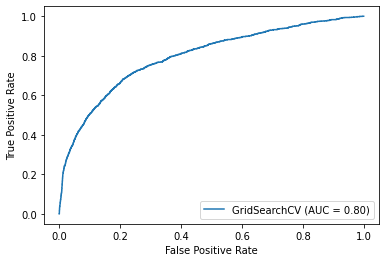

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.0min finished


[0.65036478 0.65307769 0.66668335 0.69083216 0.715342   0.72525412
 0.72736564 0.72869488 0.72925512]
[0.64941204 0.65204994 0.66445457 0.68365753 0.69714042 0.69858308
 0.69789082 0.69724004 0.69702566]
{'C': 5}
0.6985830788564572
ROC AUC for feature LABEL_AST  :  0.7241424733784952


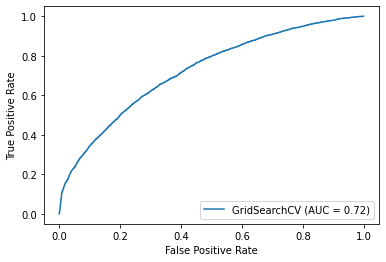

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.0min finished


[0.652446   0.65472157 0.6659066  0.68951344 0.71637647 0.72707429
 0.72926082 0.73059301 0.73114174]
[0.65140472 0.65351787 0.66343162 0.68195933 0.69768781 0.69973734
 0.69914547 0.6985263  0.69835425]
{'C': 5}
0.699737340142434
ROC AUC for feature LABEL_Alkalinephos  :  0.7259223702281424


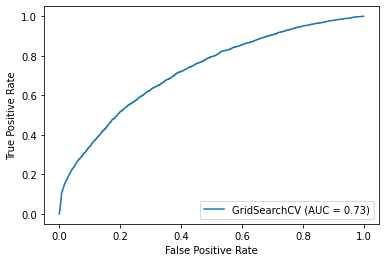

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.1s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   58.5s finished


[0.65182437 0.65506342 0.67146039 0.69689282 0.72078789 0.73068412
 0.73277616 0.73406594 0.73460089]
[0.65082797 0.65378222 0.66891176 0.68952548 0.70338451 0.70505766
 0.70454087 0.70401444 0.70376082]
{'C': 5}
0.705057661537235
ROC AUC for feature LABEL_Bilirubin_total  :  0.7296550102582967


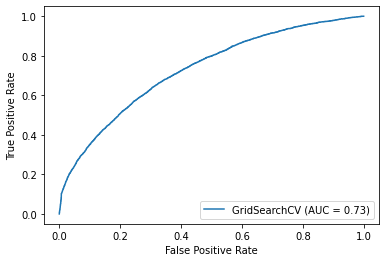

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.7s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   53.9s finished


[0.72708547 0.72951643 0.74155187 0.76105052 0.7806264  0.78927174
 0.79089258 0.79169894 0.79193546]
[0.7265767  0.72890391 0.74017758 0.75633113 0.7675117  0.76856956
 0.76743881 0.76612857 0.76549783]
{'C': 5}
0.7685695639018122
ROC AUC for feature LABEL_Lactate  :  0.7883622544049022


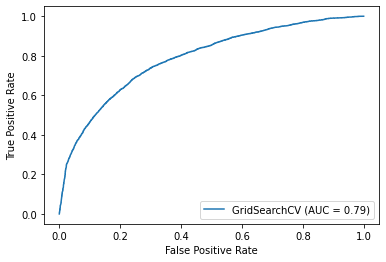

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.2s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   58.5s finished


[0.67708872 0.68960476 0.74051118 0.79375303 0.83498317 0.85135631
 0.85517639 0.85761613 0.85857063]
[0.67523434 0.68741011 0.73661673 0.78489949 0.81774339 0.82707345
 0.82830297 0.8286316  0.82858572]
{'C': 20}
0.8286316017464064
ROC AUC for feature LABEL_TroponinI  :  0.856362480519681


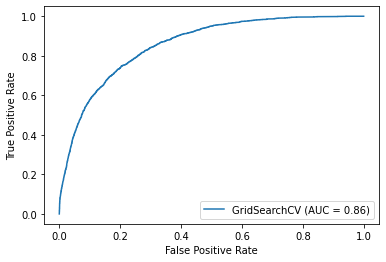

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.8s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   57.7s finished


[0.75932685 0.76146127 0.77116413 0.78920805 0.80718479 0.81378892
 0.81519012 0.81598198 0.81626377]
[0.75899712 0.76100152 0.76998293 0.78459116 0.79495553 0.79523197
 0.79432047 0.79308001 0.79252964]
{'C': 5}
0.7952319665960842
ROC AUC for feature LABEL_SaO2  :  0.8129562743627226


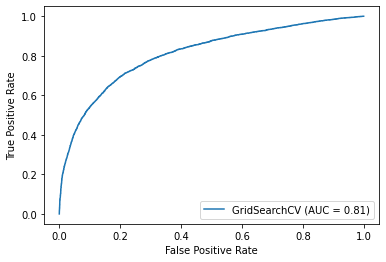

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    4.0s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:  1.1min finished


[0.69025596 0.69557985 0.72549851 0.76911756 0.80824603 0.82903043
 0.83483872 0.8387328  0.84024823]
[0.68812525 0.6925527  0.71704721 0.74589317 0.74938272 0.73929518
 0.73330985 0.72703706 0.72375426]
{'C': 1}
0.7493827236541727
ROC AUC for feature LABEL_Bilirubin_direct  :  0.8062103170372358


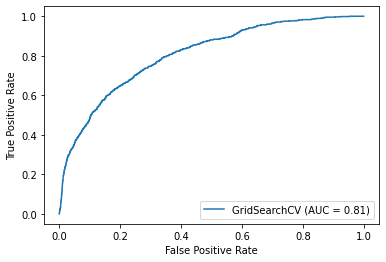

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.6s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   52.5s finished


[0.80093907 0.80822601 0.84250642 0.89259113 0.91964377 0.9291824
 0.93174052 0.93340669 0.93403289]
[0.79962386 0.80666681 0.83959447 0.88410968 0.89989412 0.89951115
 0.89798863 0.89645781 0.89549625]
{'C': 1}
0.8998941193537272
ROC AUC for feature LABEL_EtCO2  :  0.9191694294845186


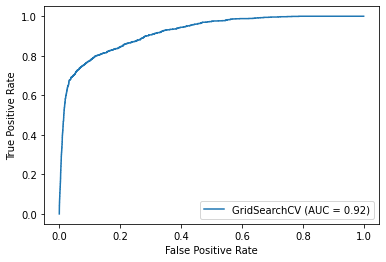

Fitting 10 folds for each of 9 candidates, totalling 90 fits


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    3.4s
[Parallel(n_jobs=6)]: Done  90 out of  90 | elapsed:   54.8s finished


[0.64848561 0.65117644 0.66766117 0.70237395 0.73396541 0.74745776
 0.75021965 0.75165323 0.75210921]
[0.64583769 0.64799017 0.66000429 0.67776903 0.67834515 0.66772691
 0.6626826  0.65850465 0.65687975]
{'C': 1}
0.6783451491708166
ROC AUC for feature LABEL_Sepsis  :  0.731674620342357


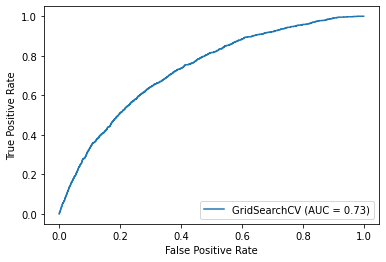

In [27]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

from sklearn.linear_model import LogisticRegression
from sklearn.kernel_approximation import Nystroem
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import plot_roc_curve

for i in range(1, 12):
    #     feature selection
    transformer =  GenericUnivariateSelect(score_func= f_classif, mode ='k_best', param = 60)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)

    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=300)
    
    train_transformed = feature_map_nystroem.fit_transform(train_features)
    test_transformed = feature_map_nystroem.transform(test_features)

#     weights = data_train.shape[0] / (2 * np.bincount(df_train_labels.iloc[:,i]))
#     class_1_multiplier = 2
#     print(np.sum(class_1))
#     print(np.sum(class_0))
#     class_weight = {0:weights[0], 1:(class_1_multiplier*weights[1])}
    clf_w = LogisticRegression(penalty = 'l2', class_weight = 'balanced',
                                                               fit_intercept= True, max_iter=10000)
    
    # checked before
    #parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    parameters = {'C':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    
    skf = StratifiedKFold(n_splits=10, shuffle = True, random_state = 1)
    
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = skf,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_transformed, df_train_labels.iloc[:,i])
    
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
#     print("Class weightt is ", clf_w.class_weight_)
 
    probability_tmp = clf.predict_proba(test_transformed)
    probability = [item[1] for item in probability_tmp]
    columns_1.append(probability)

    probability_tmp = clf.predict_proba(train_transformed)
    probability_train = [item[1] for item in probability_tmp]
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    
    svc_disp = plot_roc_curve(clf, train_transformed, df_train_labels.iloc[:,i])
    plt.show()

# Compute the kernel and use SGD Classifier and Regressor

In [ ]:
# first for the labels that have an output [0,1]
columns_1 = [test_pids]

# from sklearn.kernel_ridge import KernelRidge
from sklearn.kernel_approximation import Nystroem
from sklearn import linear_model


for i in range(1, 12):
   
    # feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_classif, mode ='k_best', param=70)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
    print("For feature ", df_train_labels.columns[i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)

    
    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=300)
    train_transformed = feature_map_nystroem.fit_transform(train_features)
    test_transformed = feature_map_nystroem.transform(test_features)
    
    clf_w = linear_model.SGDClassifier(max_iter=100000, tol=1e-4, penalty = "l2", 
                                       loss = "epsilon_insensitive", class_weight={0:1, 1:500})
    # checked before
    #parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10, 20, 30)}
    parameters = {'alpha':(0.1, 1, 5, 10)}
    
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    clf.fit(train_transformed, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.best_params_)
    print(clf.best_score_)
    # compute probabilites as opposed to predictions
    #dual_coefficients = clf.dual_coef_    # do we have to normalize with norm of this vector ?
    
    distance_hyperplane = clf.decision_function(test_transformed)
    probability = np.empty(len(distance_hyperplane))
    for j in range(0, len(probability)):
        if distance_hyperplane[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplane[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplane[j]))
    columns_1.append(probability)

    
    distance_hyperplace_train = clf.decision_function(train_transformed)
    probability = np.empty(len(distance_hyperplace_train))
    for j in range(0, len(probability)):
        if distance_hyperplace_train[j] < 0:
            probability[j] = 1 - 1/(1 + math.exp(distance_hyperplace_train[j]))
        else:
            probability[j] = 1/(1 + math.exp(-distance_hyperplace_train[j]))
    
    tmp = roc_auc_score(y_score= probability, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)
    

In [ ]:
# labels that have a real value
columns_2 = []

for i in range(12, 16):
#     feature selection
    transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param = 40)
    train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
#     print(df_train_agg_features.columns[transformer.get_support(indices = True)])
    test_features = transformer.transform(data_test_scaled)
    
    feature_map_nystroem = Nystroem(kernel = 'rbf',
                                 random_state=1,
                                 n_components=200)
    train_features = feature_map_nystroem.fit_transform(train_features)
    test_features = feature_map_nystroem.transform(test_features)
    
    clf_w = linear_model.SGDRegressor(max_iter=100000, tol=1e-4,
                                     loss = 'epsilon_insensitive', penalty = 'l2')
    parameters = {'alpha':(0.0001, 0.001, 0.01, 0.1, 1, 5, 10)}
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = parameters, cv = 10,
                                       refit = True, scoring = 'r2', verbose = 1, n_jobs=6, return_train_score=True)
#     clf = KernelRidge(kernel = 'poly', degree = 5)
#     parameters = {'alpha':(0.1,1,10,30)}
#     clf = model_selection.GridSearchCV(estimator= clf, param_grid = parameters, cv = 3,
#                                       refit = True, scoring = 'r2', verbose = 2, n_jobs=6)
    clf.fit(train_features, df_train_labels.iloc[:,i])
    
#     print(clf.cv_results_)
    print(clf.cv_results_['mean_train_score'])
    print(clf.cv_results_['mean_test_score'])
    print(clf.best_params_)
    print(clf.best_score_)
    
    pred = clf.predict(test_features)
    columns_2.append(pred) 

    pred_train = clf.predict(train_features)
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
   

In [ ]:
columns_final = columns_1 + columns_2

# XGBoosting

The benefit of XGBoost is that it accepts missing values.

In [ ]:
import xgboost as xgb
# simple example
# load file from text file, also binary buffer generated by xgboost

# scale test data
min_max_scaler = preprocessing.StandardScaler()
df_train_scaled_xgboost = min_max_scaler.fit_transform(df_train_agg_features)
min_max_scaler = preprocessing.StandardScaler()
df_test_scaled_xgboost = min_max_scaler.fit_transform(df_test_agg_features)

dtrain = xgb.DMatrix(df_train_scaled_xgboost, label=df_train_labels.iloc[:,1])
dtest = xgb.DMatrix(df_test_scaled_xgboost)

In [ ]:
param = {'eta': 1, 'objective': 'binary:logistic', 'verbosity':1}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dtrain, 'train')]

In [ ]:
num_round = 10
xgb.cv(param, dtrain, num_round, nfold=10,
       metrics={'auc'}, seed=0,
       callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
# bst = xgb.train(param, dtrain, num_round)
# pred = bst.predict(dtest)

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.kernel_approximation import Nystroem

columns_1 = [test_pids]


for i in range(1,12):

    clf = xgb.XGBClassifier('binary:logistic')
    
    clf_w = model_selection.GridSearchCV(estimator= clf, param_grid = {'max_depth': [2,3,4,5]}, cv = 10,
                                        refit = True, scoring = 'roc_auc', verbose = 1,
                                       n_jobs=6, return_train_score = True)
    

    clf_w.fit(df_train_scaled_xgboost, df_train_labels.iloc[:,i])
    print(clf_w.best_params_)
    print(clf_w.best_score_) 
#     dtrain = xgb.DMatrix(df_train_agg_features, label=df_train_labels.iloc[:,i])
#     num_round = 10
#     xgb.cv(param, dtrain, num_round, nfold=10,
#        metrics={'auc'}, seed=0,
#        callbacks=[xgb.callback.print_evaluation(show_stdv=True)])
    
    probability = clf_w.predict(df_test_scaled_xgboost)
    columns_1.append(probability)

    probability_train = clf_w.predict(df_train_scaled_xgboost)
#     probability_train = [item[1] for item in probability_tmp]
    tmp = roc_auc_score(y_score= probability_train, y_true= df_train_labels.iloc[:,i])
    print("ROC AUC for feature", list(df_train_labels)[i] , " : ", tmp)

In [ ]:
import xgboost as xgb

columns_2_1 = []
param = {'max_depth': 2, 'eta': 1, 'objective': 'reg:squarederror', 'verbosity':1}
param['nthread'] = 4
param['eval_metric'] = 'rmse'
# evallist = [(dtrain, 'train')]

train_features = data_train_scaled
test_features = data_test_scaled
for i in range(12,16):
#     transformer =  GenericUnivariateSelect(score_func= mutual_info_regression, mode ='k_best', param=80)
#     train_features = transformer.fit_transform(data_train_scaled, df_train_labels.iloc[:,i])
# #     print(list(data_train_scaled)[transformer.get_support()])
#     test_features = transformer.transform(data_test_scaled)
    
    clf_w = xgb.XGBRegressor(feval = r2_score, verbosity = 0)
            
    clf = model_selection.GridSearchCV(estimator= clf_w, param_grid = {'max_depth':(3,4,5)}, cv = 10,
                                       refit = True, verbose = 1, scoring='r2',
                                       n_jobs=6, return_train_score = True)
    
    clf.fit(data_train_scaled, df_train_labels.iloc[:,i])
    print(clf.best_params_)
    print(clf.best_score_)    
    
#     dtrain = xgb.DMatrix(df_train_scaled_xgboost, label=df_train_labels.iloc[:,i])
#     num_round = 10
    
    probability = clf.predict(data_test_scaled)
    columns_2_1.append(probability)

    pred_train = clf.predict(data_train_scaled)
#     probability_train = [item[1] for item in probability_tmp]
    tmp = r2_score(y_pred= pred_train, y_true=df_train_labels.iloc[:,i])
    print("R2 for feature", list(df_train_labels)[i] , " : ", tmp)
   

In [ ]:
columns_final = columns_1 + columns_2_1

# Neural Nets

In [35]:
NEPOCHS = 60    
BATCHSIZE = 32
VALIDATIONSPLIT = 0.2
HIDDENSIZE = 80
kfold_splits = 10

In [45]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [69]:
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import BatchNormalization
from keras.callbacks import Callback,ModelCheckpoint

def create_model():
    model = Sequential()
    model.add(Dense(HIDDENSIZE, input_dim = data_train_scaled.shape[1], activation='relu'))
    model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
    model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
#     model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
#     model.add(Dropout(0.2))
#     model.add(BatchNormalization(momentum=0.9))

    model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
    # model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
    # model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
    # model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
    # model.add(BatchNormalization(momentum=0.7))
    # model.add(Dropout(0.2))

    model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
    # model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
    # model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
    # model.add(Dense(HIDDENSIZE, input_dim = HIDDENSIZE, activation='relu'))
#     model.add(Dropout(0.5))
#     model.add(BatchNormalization(momentum=0.9))

    model.add(Dense(1, input_dim = HIDDENSIZE, activation='relu'))



    model.compile(optimizer='rmsprop',
                loss='mean_squared_error',
                metrics=[coeff_determination])
    return model

In [70]:
from sklearn.model_selection import KFold
columns_2_1 = []

mode_path = './models/mlp_v2.h5'

model = None
model = create_model()
model.summary()

best_fold = -1
best_score = 0
best_model = None

folds = KFold(n_splits=10, shuffle=True, random_state=1)
index = 0
for train_indices, val_indices in folds.split(data_train_scaled):
    print("Training on fold " + str(index+1) + "/10...")
    # Generate batches from indices
    xtrain, xval = data_train_scaled.iloc[train_indices,:], data_train_scaled.iloc[val_indices,:]
    ytrain, yval = df_train_labels.iloc[train_indices, 14], df_train_labels.iloc[val_indices, 14]

    # xtrain_onehot = onehot_encoder.transform(xtrain)
    # xval_onehot = onehot_encoder.transform(xval)
    # ytrain_onehot = keras.utils.to_categorical(y_train, num_classes=2)
    # yval_onehot = keras.utils.to_categorical(y_val, num_classes=2)

    model = None
    model = create_model()

    # model.summary()
    callbacks = [ModelCheckpoint(filepath=mode_path, save_best_only=True)]
    model.fit(xtrain, ytrain, validation_data = (xval, yval), epochs = NEPOCHS, batch_size=BATCHSIZE, verbose = 0,
            callbacks=callbacks)  # starts training

    # get the best fold based on the best f1 score
    y_pred = model.predict(xval, batch_size=BATCHSIZE, verbose=1)
    tmp_score = r2_score(y_true=yval ,y_pred=y_pred_bool)
    print("R2 score for this fold is : ", tmp_score)
    if(tmp_score > best_score):
        best_fold = index
        best_model = model

    index = index + 1

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_99 (Dense)             (None, 80)                18560     
_________________________________________________________________
dense_100 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_101 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_102 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_103 (Dense)            (None, 80)                6480      
_________________________________________________________________
dense_104 (Dense)            (None, 1)                 81        
Total params: 44,561
Trainable params: 44,561
Non-trainable params: 0
_________________________________________________

KeyboardInterrupt: 

## Save predictions

In [ ]:
print(np.shape(columns_final))
result = pd.DataFrame(columns_final).transpose()
result.columns = list(df_train_labels)
result.to_csv('./Results/prediction.csv.zip', index=False, float_format='%.3f', compression='zip')

In [ ]:
result.to_csv('./Results/prediction.csv', index=False, float_format='%.3f')